In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [3]:
data = pd.read_csv('emotion_dataset.csv')
data.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+','',text)
    text = re.sub(r'@\w+','',text)
    text = re.sub(r'#\w+','',text)
    text = re.sub(r'[^a-z\s]','',text)
    text = re.sub(r'\s+',' ',text).strip()
    return text

data["text"] = data["text"].astype(str).apply(preprocess_text)

In [5]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [6]:
data.head()

,text,label
0,i didnt feel humiliated,3
1,i can go from feeling so hopeless to so damned...,3
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,0


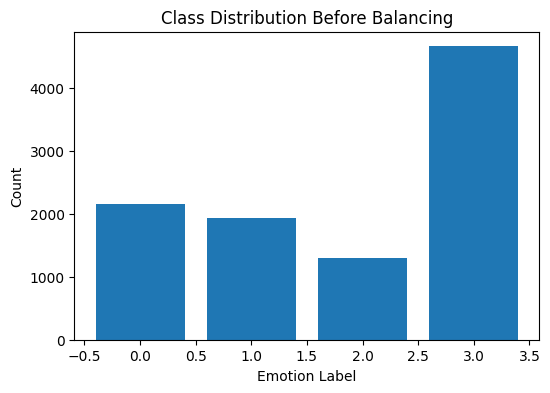

In [7]:
plt.figure(figsize=(6,4))
plt.bar(Counter(data['label']).keys(), Counter(data['label']).values())
plt.title("Class Distribution Before Balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
vocab_size = len(tokenizer.word_index) + 1
max_length = 100

X = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(X, maxlen=max_length, padding='post')
y = data['label'].values

In [9]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

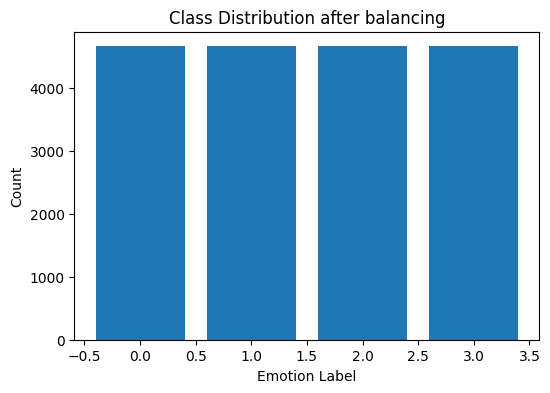

In [10]:
plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title("Class Distribution after balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2,random_state=42)

In [12]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(len(np.unique(y_resampled)), activation='softmax')
])

d:\vs-codes\Projects\MachineLearning-Projects\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 173s 392ms/step - accuracy: 0.3737 - loss: 1.4945 - val_accuracy: 0.8936 - val_loss: 0.3923
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 141s 335ms/step - accuracy: 0.9395 - loss: 0.1966 - val_accuracy: 0.9525 - val_loss: 0.1560
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 141s 335ms/step - accuracy: 0.9773 - loss: 0.0786 - val_accuracy: 0.9632 - val_loss: 0.1387
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 143s 342ms/step - accuracy: 0.9851 - loss: 0.0533 - val_accuracy: 0.9518 - val_loss: 0.2209
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 152s 362ms/step - accuracy: 0.9864 - loss: 0.0441 - val_accuracy: 0.9618 - val_loss: 0.1596
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 144s 342ms/step - accuracy: 0.9883 - loss: 0.0423 - val_accuracy: 0.9632 - val_loss: 0.1733
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 227s 403ms/step - accuracy: 0.9883 - loss: 0.0396 - val_accuracy: 0.9652 - val_loss: 0.1357
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 175s 416ms/step - accuracy: 0.9909 -

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss:.3f}, Test accuracy: {test_accuracy:.3f}')

Test loss: 0.113, Test accuracy: 0.975


In [17]:
import joblib

model.save("emotion_model.keras")

joblib.dump(tokenizer, "tokenizer.jb")
joblib.dump(label_encoder, "label_encoder.jb")

['label_encoder.jb']